In [4]:
import cv2
import numpy as np
import seaborn as sns
from time import time

from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_vp
import pygcransac
import pyprogressivex

In [5]:
img0_file = 'img/terrace0.JPG'
img0 = cv2.imread(img0_file, 0)
img1_file = 'img/terrace1.JPG'
img1 = cv2.imread(img1_file, 0)

# LSD+LBD matcher
lsd_lbd_matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')

# SOLD2 matcher
conf = {
    'sold2': {
        'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
        'device': 'cpu'
    }
}
sold2_matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

## Line detection and description

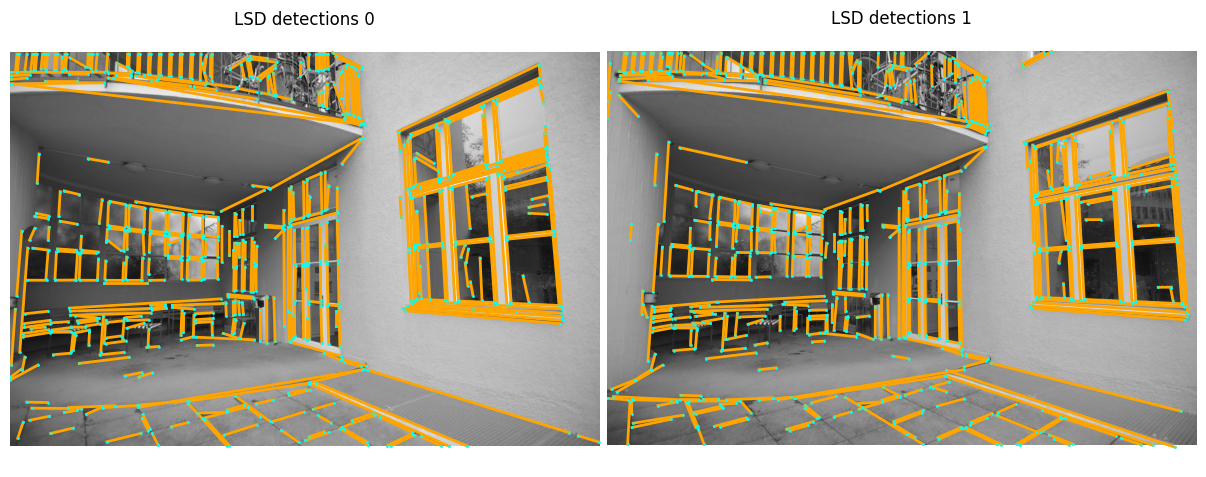

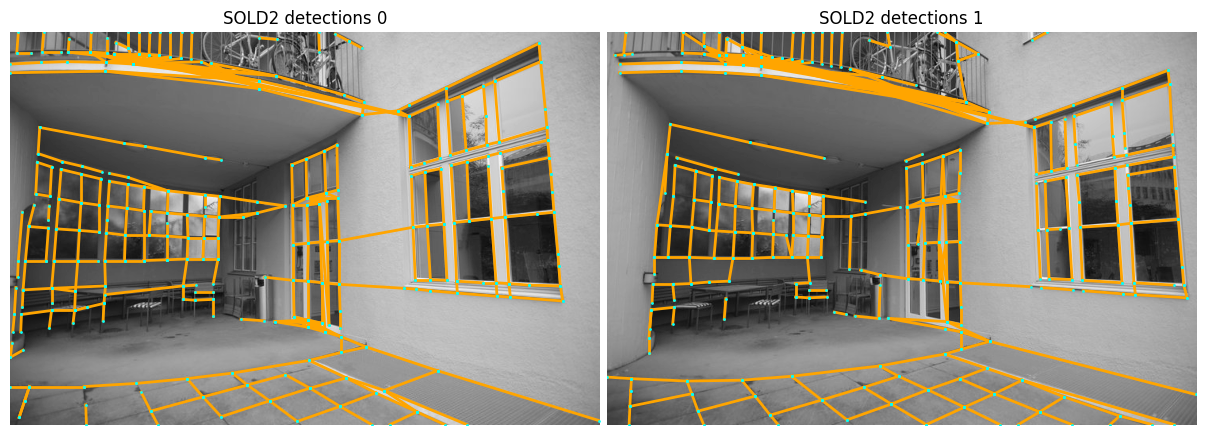

In [6]:
## LSD detections
lsd_lbd_features0 = lsd_lbd_matcher.detect_and_describe_lines(img0)
lsd_lbd_features1 = lsd_lbd_matcher.detect_and_describe_lines(img1)

## SOLD2 detections
sold2_features0 = sold2_matcher.detect_and_describe_lines(img0)
sold2_features1 = sold2_matcher.detect_and_describe_lines(img1)

# Display the detections
plot_images([img0, img1], ['LSD detections 0', 'LSD detections 1'])
plot_lines([lsd_lbd_features0["line_segments"][:, :, [1, 0]], lsd_lbd_features1["line_segments"][:, :, [1, 0]]])
plot_images([img0, img1], ['SOLD2 detections 0', 'SOLD2 detections 1'])
plot_lines([sold2_features0["line_segments"][:, :, [1, 0]], sold2_features1["line_segments"][:, :, [1, 0]]])

## Line matching

Computing LBD matching with ARPACK adjacenceVec size: [2183005 x 1]


/home/danini/anaconda3/envs/homography/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


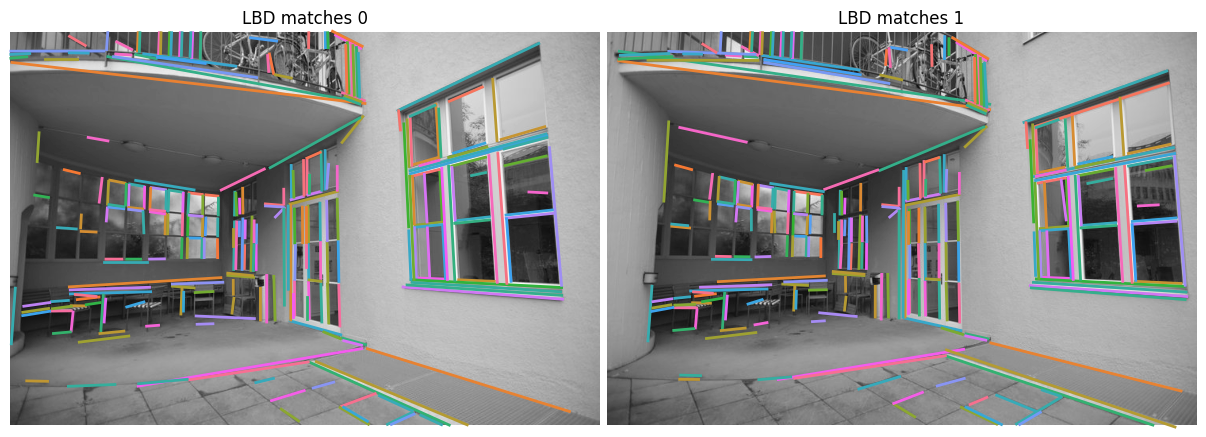

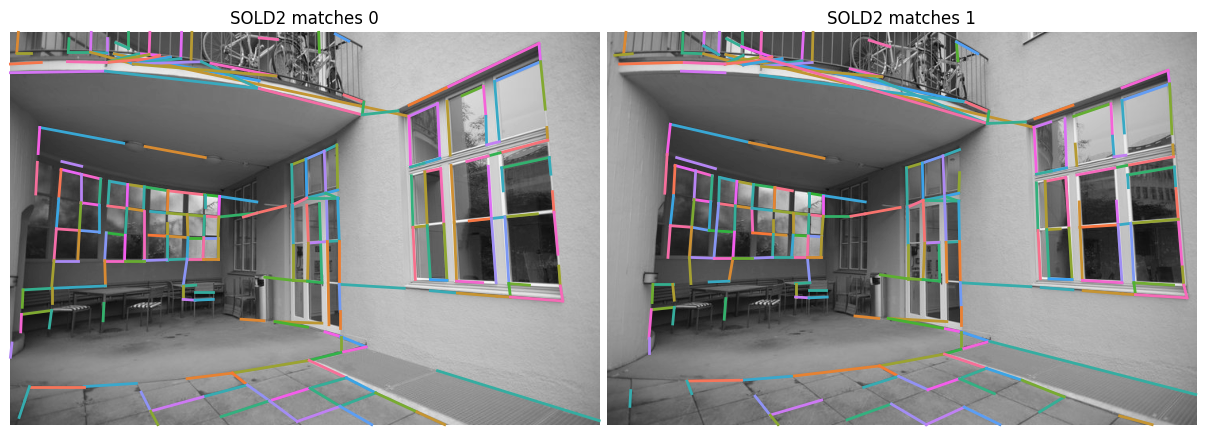

In [7]:
## LBD matching
_, m_lines0_lbd, m_lines1_lbd = lsd_lbd_matcher.match_lines(img0, img1, lsd_lbd_features0, lsd_lbd_features1)

## SOLD2 matching
_, m_lines0_sold2, m_lines1_sold2 = sold2_matcher.match_lines(img0, img1, sold2_features0, sold2_features1)

# Plot the matches
plot_images([img0, img1], ['LBD matches 0', 'LBD matches 1'])
plot_color_line_matches([m_lines0_lbd[:, :, [1, 0]], m_lines1_lbd[:, :, [1, 0]]])
plot_images([img0, img1], ['SOLD2 matches 0', 'SOLD2 matches 1'])
plot_color_line_matches([m_lines0_sold2[:, :, [1, 0]], m_lines1_sold2[:, :, [1, 0]]])

## Vanishing point estimation

In [26]:
def verify_pyprogressivex(img, lines_segments, threshold = 2.0):     

    lines = []
    weights = []
    for i in range(lines_segments.shape[0]):
        p0 = lines_segments[i,0]
        p1 = lines_segments[i,1]
        p2 = lines_segments[i,2]
        p3 = lines_segments[i,3]
        len1 = np.linalg.norm(p1 - p0)
        len2 = np.linalg.norm(p3 - p2)
        lines.append([p0[0], p0[1], p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]])
        weights.append(len1 + len2)

    lines = np.array(lines)
    weights = np.array(weights)    

    vanishing_points, labeling = pyprogressivex.findCommonVanishingPoints(
        np.ascontiguousarray(lines), 
        np.ascontiguousarray(weights), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.99,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 5,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)    
    return vanishing_points, labeling


In [33]:
from random import randint
import matplotlib.pyplot as plt

def draw_results(img, model_number, labeling, linesegments, vanishing_points, colors = None):
    line_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    max_inlier_number = 0

    for idx in range(model_number):    
        mask = np.zeros(len(labeling))
        indices = [i for i, e in enumerate(labeling) if e == idx]
        
        if colors == None:
            color = (randint(0, 255), randint(0, 255), randint(0, 255))
        else:
            color = colors[idx]

        vp = vanishing_points[idx]

        #print("Drawing the lines assigned to the {}-th vanishing point.".format(int(idx + 1)))
        #print(f"# inliers = {len(indices)}")
        
        for i in indices:
            # Draw the line
            pt1i = (int(linesegments[i, 0, 0]), int(linesegments[i, 0, 1]))
            pt2i = (int(linesegments[i, 1, 0]), int(linesegments[i, 1, 1]))
            width = 6 #linesegments[i, 4]
            
            cv2.line(line_img, pt1i, pt2i, color, int(np.ceil(width / 2)))
        
        if abs(vp[2]) < 1e-10:
            continue

        vp /= vp[2]
        vp = (int(vp[0]), int(vp[1]))

        cv2.circle(line_img, vp, 7, (255, 255, 255), -1)
        cv2.circle(line_img, vp, 5, color, -1)
        
    return line_img

Runtime = 0.015 secs


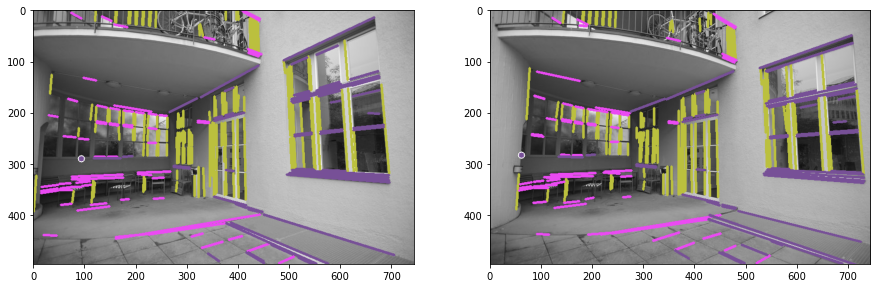

Runtime = 0.016 secs


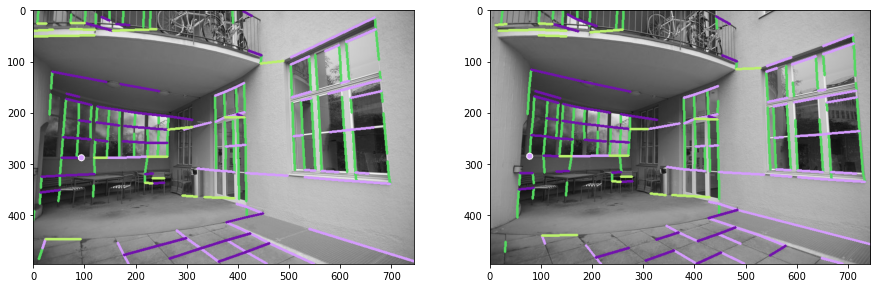

In [38]:
if True:
    plt.figure(figsize = (15,10))

    # The matched line segments in the two images
    m_lines0_lbd_inl = m_lines0_lbd[:, :, [1, 0]]
    m_lines1_lbd_inl = m_lines1_lbd[:, :, [1, 0]]

    # The line matches
    line_matches = np.concatenate([m_lines0_lbd_inl, m_lines1_lbd_inl], axis=1)

    # Finding vanishing points in a joint manner
    t = time()
    vanishing_points, labeling = verify_pyprogressivex(img0, line_matches, threshold=1.5)
    print(f"Runtime = {time() - t:.3f} secs")
    
    # Number of vanishing points
    model_number = vanishing_points.shape[0]

    # Generating colors so they can be used for drawing the matching lines
    colors = []
    for i in range(model_number):
        colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))

    vp_img0 = draw_results(img0, model_number, labeling, m_lines0_lbd_inl, vanishing_points[:, 0:3], colors = colors)
    plt.subplot(1, 2, 1)
    plt.imshow(vp_img0)

    vp_img1 = draw_results(img1, model_number, labeling, m_lines1_lbd_inl, vanishing_points[:, 3:6], colors = colors)
    plt.subplot(1, 2, 2)
    plt.imshow(vp_img1)
    plt.show()

if True:
    plt.figure(figsize = (15,10))

    # The matched line segments in the two images
    m_lines0_sold2_inl = m_lines0_sold2[:, :, [1, 0]]
    m_lines1_sold2_inl = m_lines1_sold2[:, :, [1, 0]]

    # The line matches
    line_matches = np.concatenate([m_lines0_sold2_inl, m_lines1_sold2_inl], axis=1)

    # Finding vanishing points in a joint manner
    t = time()
    vanishing_points, labeling = verify_pyprogressivex(img0, line_matches, threshold=1.5)
    print(f"Runtime = {time() - t:.3f} secs")
    
    # Number of vanishing points
    model_number = vanishing_points.shape[0]

    # Generating colors so they can be used for drawing the matching lines
    colors = []
    for i in range(model_number):
        colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))

    vp_img0 = draw_results(img0, model_number, labeling, m_lines0_sold2_inl, vanishing_points[:, 0:3], colors = colors)
    plt.subplot(1, 2, 1)
    plt.imshow(vp_img0)

    vp_img1 = draw_results(img1, model_number, labeling, m_lines1_sold2_inl, vanishing_points[:, 3:6], colors = colors)
    plt.subplot(1, 2, 2)
    plt.imshow(vp_img1)
    plt.show()
